# IIS - Deep Learning Lab

Welcome to the deep learning IIS lab! In this lab we will explore some basic deep learning techniques, some known pitfalls and possible applications.
This lab is based on the official Keras documentation and the following book: https://www.deeplearningbook.org.
First, let's install the required libraries.

In [1]:
!pip -q install --user tensorflow
!pip -q install --user keras
!pip -q install --user sklearn
!pip -q install --user numpy
!pip -q install --user seaborn
!pip -q install --user matplotlib

  Preparing metadata (setup.py) ... done


# Warming up with XOR
The first part of the exercise will focus on feedforward neural networks. As a warm-up let's consider a simple XOR problem.

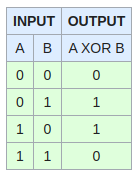

In [2]:
# Required imports first
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)
sns.set_style("whitegrid")


def plot_history(history):
  """
  A simple function that plots the loss history of a trained neural network.
  Args:
    history: A Keras loss object
  """
  sns.lineplot(x=list(range(len(history.history['loss']))), y=history.history['loss'])
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss during training")
  plt.show()

In [3]:
# Let's create the data set next.
# Assuming Bernoully-distributed variables A,B, we draw 1k samples.
# by computing XOR(A,B) we get the target.

A = np.random.randint(0,2, 1000)
B = np.random.randint(0,2, 1000)

C = np.logical_xor(A,B)
C = np.array(C, dtype = int)

# Let's joint the arrays into a single numpy matrix
whole_space = np.vstack([A,B,C]).T
print(whole_space)

# Let's make a split of the data
train_data = whole_space[:750,[0,1]] # Training instances
train_target = whole_space[:750, 2] # Training targets
test_data = whole_space[750:,[0,1]] # Testing instances
test_target = whole_space[750:, 2] # Testing targets

[[0 1 1]
 [1 0 1]
 [0 0 0]
 ...
 [1 0 1]
 [1 0 1]
 [0 0 0]]


The loss function considered will be the _binary cross-entropy_;
$$\textrm{BCE}(\theta) = - \frac{1}{n}\sum_{i = 1}^{n}\underbrace{y_i - \log{(p(y_i; \theta))}}_{\textrm{positive class}} +  \underbrace{(1-y_i) \log{(1 - p(y_i; \theta))}}_\textrm{Negative class}.$$
Here, $p(y_i; \theta)$ is the probability of the positive label given the parameter space $\theta$, $y_i$ the ground truth label (either 0 or 1) and $n$ the number of samples.

Epoch 1/100
47/47 [==============================] - 7s 5ms/step - loss: 0.7436 - accuracy: 0.2520
Epoch 2/100
47/47 [==============================] - 0s 7ms/step - loss: 0.7326 - accuracy: 0.2493
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: 0.7233 - accuracy: 0.2493
Epoch 4/100
47/47 [==============================] - 0s 6ms/step - loss: 0.7158 - accuracy: 0.2493
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: 0.7093 - accuracy: 0.2493
Epoch 6/100
47/47 [==============================] - 0s 6ms/step - loss: 0.7039 - accuracy: 0.3787
Epoch 7/100
47/47 [==============================] - 0s 6ms/step - loss: 0.6990 - accuracy: 0.4733
Epoch 8/100
47/47 [==============================] - 0s 5ms/step - loss: 0.6945 - accuracy: 0.4733
Epoch 9/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6905 - accuracy: 0.4733
Epoch 10/100
47/47 [==============================] - 0s 8ms/step - loss: 0.6864 - accuracy: 0.6360
Epoch 11

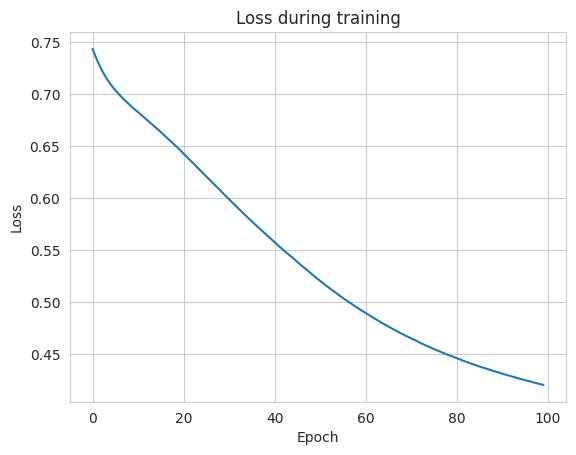

In [4]:
# We will use the Keras API for constructing the neural networks
model = keras.Sequential() # Initialization of the Sequential object. Homework: What other types of APIs are possible?
model.add(keras.Input(shape=(2,))) # First layer is just an input wrapper.
model.add(layers.Dense(2, activation="elu")) # Dense + activation
model.add(layers.Dense(1, activation="sigmoid")) # Dense + final activation. Discussion time: why sigmoid?
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # Model compilation. Optimizer and loss are needed here.

# Discussion time: Let's discuss the loss.

history = model.fit(train_data, train_target, epochs=100, batch_size=16)
plot_history(history)

In [5]:
# Did we learn anything?
predictions = np.round(model.predict(test_data))
score = accuracy_score(predictions, test_target)
print(f"Neural network performed with the accuracy of {score}")

predictions_random = np.random.randint(0,2, len(predictions))
score_random = accuracy_score(predictions_random, test_target)
print(f"Random baseline performed with the accuracy of {score_random}")

8/8 [==============================] - 0s 4ms/step
Neural network performed with the accuracy of 0.776
Random baseline performed with the accuracy of 0.484


Mini tasks to better understand the learning part:

1. Try to change the activation and the number of hidden neurons.

2. Try to omit the activation alltogether, what do you observe? (HINT: Think in terms of linear separability)



The next example will consider the well known _iris_ data set. Here, we are doing the _multiclass_ classification!

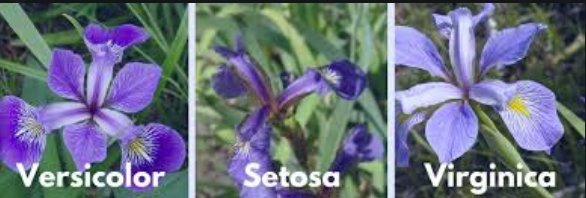

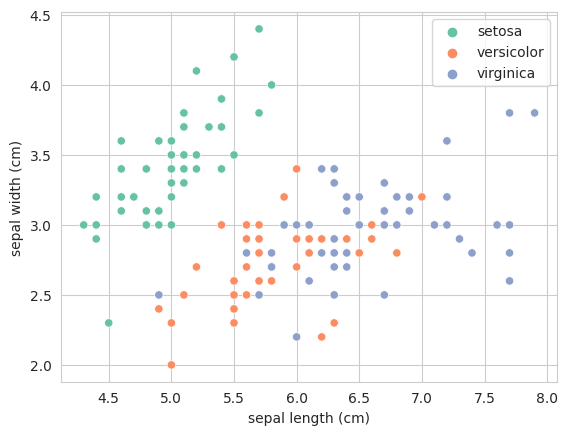

In [6]:

# We will first of all load the Iris data set
data = load_iris()
X = data['data']
Y = data['target']
names = data['feature_names']
tnames = data['target_names']

# Let's just encode the target via real names for the visualization purposes
target_vec_names = []
for el in Y:
  if el == 0:
    target_vec_names.append(tnames[0])
  elif el == 1:
    target_vec_names.append(tnames[1])
  else:
    target_vec_names.append(tnames[2])

# Plot a scatterplot (Seaborn library)
sns.scatterplot(x=X[:,0],y=X[:,1], hue = target_vec_names, palette = "Set2")
plt.xlabel(names[0])
plt.ylabel(names[1])
plt.show()

# As this is a multiclass problem, let's perform a one-hot encoding (Discussion time: what is this?)
unique_classes = len(np.unique(Y))
Y = Y.reshape(-1,1)
encoder = OneHotEncoder().fit(Y)
Y = np.asarray(encoder.transform(Y).todense()) # -> dense matrices are natively supported in Keras.

# Let's split the data in stratified manner next
X_train, X_test, Y_train, Y_test = train_test_split(np.asarray(X), np.asarray(Y), test_size=0.25, stratify=np.asarray(Y), random_state=42)

In [7]:


def construct_simple_network(n_hidden = 1, dropout = 0.5):
  """
  A supporting method useful for exploring various hyperparameter settings. The idea is that it constructs and compiles the model,
  which can be subsequently trained in an e.g., loop-like structure.
  Args:
      n_hidden (int): The number of hidden layers
      dropout (float): The dropout level after each ELU activated hidden layer
  """
  model = keras.Sequential()
  model.add(keras.Input(shape=(X_train.shape[1],)))
  for j in range(n_hidden):
    model.add(layers.Dense(8, activation="elu"))
    model.add(layers.Dropout(dropout))
  model.add(layers.Dense(unique_classes, activation="softmax"))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# Construct a network here
model = construct_simple_network()

# Model summary gives us insight w.r.t. the model properties
model.summary()

# Model fitting via standard Sklearn-like API call
history = model.fit(X_train, Y_train, epochs=200, batch_size=4, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                                 
Total params: 67 (268.00 Byte)
Trainable params: 67 (268.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
28/28 [==============================] - 3s 5ms/step - loss: 1.8297 - accuracy: 0.4643
Epoch 2/200
28/28 [==============================] - 0s 5ms/step - loss: 1.2696 - accuracy: 0.4464
Epoch 3/200
28/28 [==============================] - 0s 4ms/step - loss: 1.4587 - ac

In [8]:
# Did the model learn anything?
from sklearn.metrics import accuracy_score

# We collect max column indices (class predictions)
predictions = np.argmax(model.predict(X_test),axis = 1)

# Decode that to integers (from boolean)
Y_test = encoder.inverse_transform(Y_test)

# Compute the performance.
report_accuracy = accuracy_score(predictions, Y_test)
print(f"The performance accuracy on the test set is {report_accuracy}")

2/2 [==============================] - 0s 3ms/step
The performance accuracy on the test set is 0.9736842105263158


In [9]:
import pandas as pd
import tqdm

# Parameter space to be explored
num_hidden = [1 ,2 ,3, 4]
n_epochs = [16, 64, 128]
dropout_levels = [0.1, 0.5, 0.9]
dropout_results = []

for hidden_layers in tqdm.tqdm(num_hidden):
  for n_epo in  n_epochs:
    for dropout_level in dropout_levels:
      # Let's split the data in stratified manner next
      X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=42)

      # A call to the network constructor method
      neural_net = construct_simple_network(n_hidden = hidden_layers, dropout = dropout_level)

      # A call to the fit method with specified hyperparameters
      neural_net.fit(X_train, Y_train, epochs=n_epo, batch_size=32, verbose=0)

      # Get discrete predictions
      predictions = np.argmax(neural_net.predict(X_test),axis = 1)

      # Decode them to a single vector
      Y_test = encoder.inverse_transform(Y_test)

      # Compute accuracy
      report_accuracy = accuracy_score(predictions, Y_test)

      # Store the results to a table for further analysis
      dropout_results.append([hidden_layers, n_epo, dropout_level, report_accuracy])

  0%|          | 0/4 [00:00<?, ?it/s]

2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


 25%|██▌       | 1/4 [00:18<00:56, 19.00s/it]

2/2 [==============================] - 0s 7ms/step


 50%|█████     | 2/4 [00:39<00:39, 19.70s/it]

2/2 [==============================] - 0s 6ms/step


 75%|███████▌  | 3/4 [01:05<00:22, 22.52s/it]

2/2 [==============================] - 0s 9ms/step


100%|██████████| 4/4 [01:38<00:00, 24.58s/it]


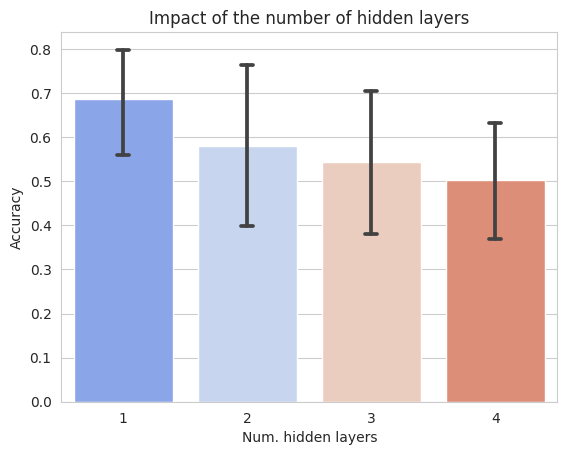

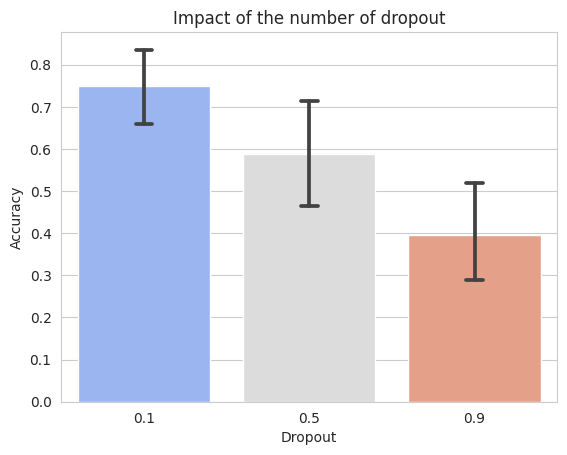

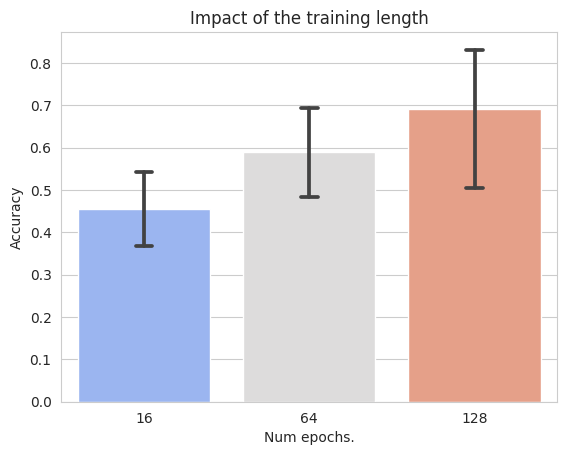

    layers  epochs  dropout  accuracy
24       3     128      0.1  0.973684
16       2     128      0.5  0.947368
15       2     128      0.1  0.947368
7        1     128      0.5  0.894737
12       2      64      0.1  0.868421


In [10]:
final_dataframe = pd.DataFrame(dropout_results)
final_dataframe.columns = ['layers', 'epochs', 'dropout','accuracy']
final_dataframe = final_dataframe.sort_values(by = ["accuracy"], ascending = False)

# Can we overfit?
sns.barplot(x=final_dataframe.layers, y=final_dataframe.accuracy, capsize = 0.1, palette = "coolwarm")
plt.xlabel("Num. hidden layers")
plt.ylabel("Accuracy")
plt.title("Impact of the number of hidden layers")
plt.show()

# How does dropout impact the performance
sns.barplot(x=final_dataframe.dropout, y=final_dataframe.accuracy, capsize = 0.1, palette = "coolwarm")
plt.xlabel("Dropout")
plt.ylabel("Accuracy")
plt.title("Impact of the number of dropout")
plt.show()

# Does training time impact the performance?
sns.barplot(x=final_dataframe.epochs, y=final_dataframe.accuracy, capsize = 0.1, palette = "coolwarm")
plt.xlabel("Num epochs.")
plt.ylabel("Accuracy")
plt.title("Impact of the training length")
plt.show()

# What's the best hyperparameter setting? (first row)
print(final_dataframe.head())

**Problemsets:**


1.   Try to improve the model's performance by varying the number of hyperparameters
2.   What happens if you increase the dropout? Can you interpret these results?
3.   Can you force it to overfit? How did you achieve this result? What is overfitting?



#Image classification
The next example addresses the image classification problem (MNIST). Examples of this data set can be seen below.

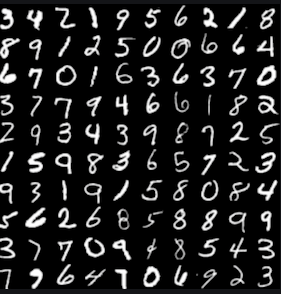

In [11]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
# Adapted from the official Docs: https://keras.io/examples/vision/mnist_convnet/

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices (one hot encoding)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


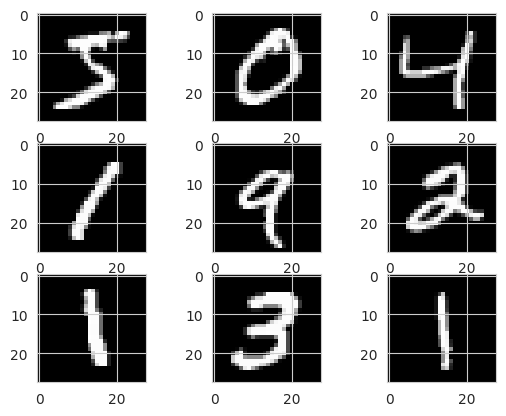

In [12]:
# Let's plot some instances next.
from matplotlib import pyplot

for i in range(0, 9):
    location = 330 + 1 + i
    pyplot.subplot(location)
    pyplot.imshow(x_train[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))

pyplot.show()

##**Model building**

The next code snipped shows the basic structure for constructing a _deep_ neural network. It consists of one main API call - the Sequential class.
The main difference to the XOR network discussed above is the use of _convolutions and _pooling_. These layers enable local aggregation of the pixel space, and when layered, offer the capability to learn potentially modular structure (lines - shapes - object etc.)

In [13]:
from IPython.display import Image
Image(url='https://miro.medium.com/max/700/1*Fw-ehcNBR9byHtho-Rxbtw.gif')

*Convolutions* are commonly coupled with a pooling operation. Let's inspect a two most common ones next to gain some intuition.

In [14]:
Image(url='https://www.researchgate.net/publication/333593451/figure/fig2/AS:765890261966848@1559613876098/Illustration-of-Max-Pooling-and-Average-Pooling-Figure-2-above-shows-an-example-of-max.png')

There are always two main steps to creating a Keras model: specification and compilation. Let's consider the folling specification:

In [15]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"), # Convolutions
        layers.MaxPooling2D(pool_size=(2, 2)), # Pooling
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout_91 (Dropout)        (None, 1600)            

In [16]:
input_shape

(28, 28, 1)

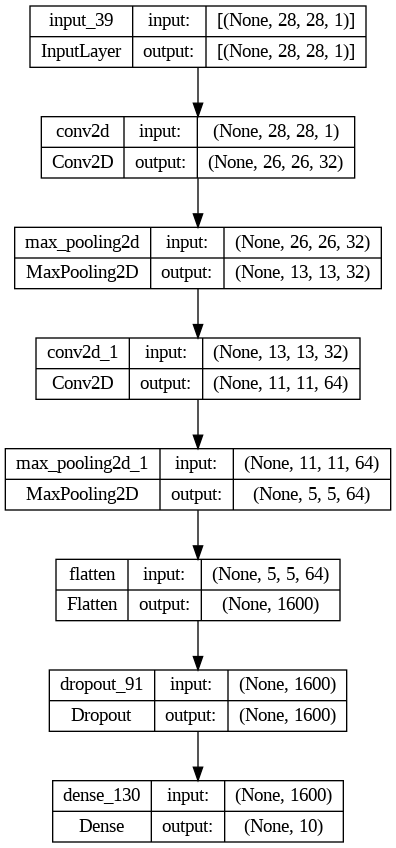

In [17]:
# Let's inspect the scheme of the model next:

keras.utils.plot_model(model, show_shapes=True)

The second step of creating a neural network involves specification of the loss function, optimizer and possible validation set metrics.

In [18]:
batch_size = 128 # How many images at once are we considering?
epochs = 3 # How many forward-backward passes are we considering?

# Model compilation -> this translates the specification above to machine code.
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Call to sklearn-like fit function. Additional hyperparameters need to be specified.
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/3
422/422 [==============================] - 8s 6ms/step - loss: 0.3543 - accuracy: 0.8929 - val_loss: 0.0837 - val_accuracy: 0.9763
Epoch 2/3
422/422 [==============================] - 2s 5ms/step - loss: 0.1083 - accuracy: 0.9671 - val_loss: 0.0543 - val_accuracy: 0.9850
Epoch 3/3
422/422 [==============================] - 3s 6ms/step - loss: 0.0825 - accuracy: 0.9743 - val_loss: 0.0503 - val_accuracy: 0.9863


In [19]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.045021623373031616
Test accuracy: 0.9854999780654907


**Problemsets:**


1.   Try increasing the batch size. What do you observe?
2.   Try printing out some examples where the network is wrong. Comment on its mistakes.



# Transfer learning

One of the key features of contemporary deep learning models is their _transferability_. Models, (pre)trained on a given task can be used to initialize a _fine tunning_ phase, which commonly consists of only a few epochs of _fine-tuning_ to a given task. This way, an average user does not need grid-scale computing for training the models from scratch, but can jump-start the learning. A powerful tool to master is the [HuggingFace](https://huggingface.co/) library, of which main focus is language modeling.

In [20]:
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.7 MB/s eta 0:00:00


In [21]:
from datasets import load_dataset
import numpy as np

# Let's load one of the text-classification data sets (https://huggingface.co/datasets)
data = load_dataset("poem_sentiment")
print(data.keys())
unique_labels = len(set(data['train']['label']))
all_texts = data['train']['verse_text']

print(f"Num all texts: {len(all_texts)}")
average_text_len = np.mean([len(x.split(" ")) for x in all_texts])
print(f"Approximate average text len (tokens): {average_text_len}")

Generating train split:   0%|          | 0/892 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/105 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/104 [00:00<?, ? examples/s]

dict_keys(['train', 'validation', 'test'])
Num all texts: 892
Approximate average text len (tokens): 7.106502242152466


In [22]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

# Define the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Pre-processing includes truncation
def preprocess_function(examples):
    return tokenizer(examples["verse_text"], truncation=True)

# Obtain tokenized documents
tokenized_data = data.map(preprocess_function, batched=True)

# Enable padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define the model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=unique_labels)

# Train arguments' specification
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
)

# Trainer object initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Train the model (fine-tune, actually)
trainer.train()

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/892 [00:00<?, ? examples/s]

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=28, training_loss=0.9233302388872419, metrics={'train_runtime': 2.8093, 'train_samples_per_second': 317.514, 'train_steps_per_second': 9.967, 'total_flos': 4803149411424.0, 'train_loss': 0.9233302388872419, 'epoch': 1.0})

In [23]:
from datasets import load_metric
from collections import Counter

# Let's obtain the predictions first
model_predictions = np.argmax(trainer.predict(tokenized_data["test"])[0], axis=1)

# Accuracy is in-built with HFTransformers
metric = load_metric("accuracy")
final_score = metric.compute(predictions=model_predictions, references=tokenized_data["test"]['label'])
print(f"Final test accuracy: {final_score}")


# Did fine-tuning actually work?
train_labels = tokenized_data['train']['label']
counter_labels_train = Counter(train_labels)
most_frequent_label = counter_labels_train.most_common(1)[0][0]

# Predict "2" for each test instance
model_predictions = np.repeat(most_frequent_label, len(model_predictions))
majority_score = metric.compute(predictions=model_predictions, references=tokenized_data["test"]['label'])
print(f"Majority classifier (label=2): {majority_score}")

<ipython-input-23-66819454582d>:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Final test accuracy: {'accuracy': 0.8461538461538461}
Majority classifier (label=2): {'accuracy': 0.6634615384615384}


**Practice**
1. Try to pre-train the DistilBERT model on the 'imdb' data set.

2. Comment on the impact of batch size on model training speed / memory consumption. Try to subsample the data (consider only 10% of the labeled data). What do you observe?

#Attention is all you need
The final exercise explores in more details the _transformer_ architecture for the task of movie review classification. This recent architecture is based on the Vaswani et al.s' paper: https://arxiv.org/abs/1706.03762.

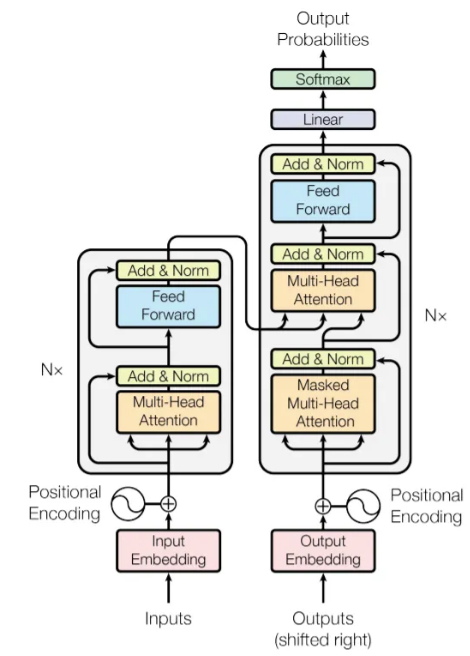

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [25]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17464789/17464789 [==============================] - 0s 0us/step
25000 Training sequences
25000 Validation sequences


In [26]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [27]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=8, validation_data=(x_val, y_val)
)

Epoch 1/8
782/782 [==============================] - 88s 98ms/step - loss: 0.3744 - accuracy: 0.8252 - val_loss: 0.2910 - val_accuracy: 0.8736
Epoch 2/8
782/782 [==============================] - 25s 31ms/step - loss: 0.2031 - accuracy: 0.9224 - val_loss: 0.3541 - val_accuracy: 0.8737
Epoch 3/8
782/782 [==============================] - 22s 29ms/step - loss: 0.1345 - accuracy: 0.9515 - val_loss: 0.3767 - val_accuracy: 0.8627
Epoch 4/8
782/782 [==============================] - 13s 17ms/step - loss: 0.0868 - accuracy: 0.9693 - val_loss: 0.5035 - val_accuracy: 0.8405
Epoch 5/8
782/782 [==============================] - 17s 22ms/step - loss: 0.0628 - accuracy: 0.9794 - val_loss: 0.5724 - val_accuracy: 0.8387
Epoch 6/8
782/782 [==============================] - 14s 18ms/step - loss: 0.0406 - accuracy: 0.9863 - val_loss: 0.6596 - val_accuracy: 0.8418
Epoch 7/8
782/782 [==============================] - 15s 20ms/step - loss: 0.0326 - accuracy: 0.9890 - val_loss: 0.7341 - val_accuracy: 0.8335

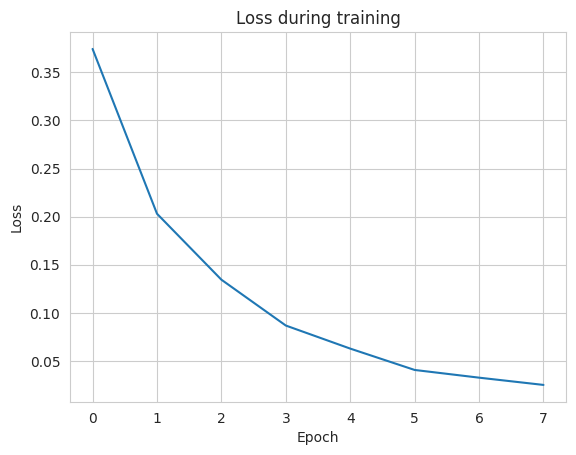

In [28]:
plot_history(history)

**Problemsets:**


1.   How does the effect of sequence length impact the performance?
2.   Try to speed up the training by selecting different hyperparameters. What do you observe?

